<a href="https://www.kaggle.com/sinamhd9/image-label-classification-opacity-vs-none?scriptVersionId=88415753" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**It is important to see if our model is able to understand the difference between chest X-ray images with and without opacities. Therefore, in this notebook, I will try to maximize the accuracy of this binary classification task.**

**If you are interested to see what model is learning (where is the model looking at), See this notebook where I implemented [GRADCAM](https://www.kaggle.com/sinamhd9/where-s-your-model-looking-at-grad-cam)**

# Imports

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from glob import glob
from tqdm.notebook import tqdm
from ast import literal_eval
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
from sklearn.metrics import accuracy_score
from skimage import exposure
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import cv2
from matplotlib.patches import Rectangle
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169, DenseNet121, DenseNet201, VGG19, Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.math import confusion_matrix

# Data manipulations

In [2]:
df_image = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')
display(df_image.head(3))
print(df_image.shape)

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7


(6334, 4)


In [3]:
df_study = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
display(df_study.head(3))
print(df_study.shape)

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0


(6054, 5)


In [4]:
df_sampleSub = pd.read_csv('../input/siim-covid19-detection/sample_submission.csv')
display(df_sampleSub.head(3))
print(df_sampleSub.shape)

,id,PredictionString
0,00188a671292_study,negative 1 0 0 1 1
1,004bd59708be_study,negative 1 0 0 1 1
2,00508faccd39_study,negative 1 0 0 1 1


(2477, 2)


In [5]:
df_study['id'] = df_study['id'].str.replace('_study',"")
df_study.rename({'id': 'StudyInstanceUID'},axis=1, inplace=True)
df_study.head(3)

,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852,0,1,0,0
1,000c9c05fd14,0,0,0,1
2,00292f8c37bd,1,0,0,0


In [6]:
df_train = df_image.merge(df_study, on='StudyInstanceUID')
df_train.head(3)

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0


In [7]:
# train_dir_jpg = '../input/covid-jpg-512/train'
# train_dir_origin ='../input/siim-covid19-detection/train'
# paths_original = []
# paths_jpg = []
# for _, row in tqdm(df_train.iterrows()):
#     image_id = row['id'].split('_')[0]
#     study_id = row['StudyInstanceUID']
#     image_path_jpg = glob(f'{train_dir_jpg}/{image_id}.jpg')
#     image_path_original = glob(f'{train_dir_origin}/{study_id}/*/{image_id}.dcm')
#     paths_jpg.append(image_path_jpg)
#     paths_original.append(image_path_original)

In [8]:
# df_train['path'] = paths_jpg
# df_train['origin'] = paths_original
# df_train.head(3)

In [9]:
df_train.loc[df_train['Negative for Pneumonia']==1, 'study_label'] = 'negative'
df_train.loc[df_train['Typical Appearance']==1, 'study_label'] = 'typical'
df_train.loc[df_train['Indeterminate Appearance']==1, 'study_label'] = 'indeterminate'
df_train.loc[df_train['Atypical Appearance']==1, 'study_label'] = 'atypical'
df_train.drop(['Negative for Pneumonia','Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance'], axis=1, inplace=True)
df_train['id'] = df_train['id'].str.replace('_image', '.jpg')
df_train['image_label'] = df_train['label'].str.split().apply(lambda x : x[0])
df_train.head(3)

,id,boxes,label,StudyInstanceUID,study_label,image_label
0,000a312787f2.jpg,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,typical,opacity
1,000c3a3f293f.jpg,NaN,none 1 0 0 1 1,ff0879eb20ed,negative,none
2,0012ff7358bc.jpg,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,typical,opacity


In [10]:
df_size = pd.read_csv('../input/covid-jpg-512/size.csv')
df_size.head(3)

,id,dim0,dim1,split
0,a29c5a68b07b.jpg,2320,2828,test
1,9850b5470fd6.jpg,2330,2382,test
2,8d6dea06a032.jpg,2422,3344,test


In [11]:
df_train = df_train.merge(df_size, on='id')
df_train.head(3)

,id,boxes,label,StudyInstanceUID,study_label,image_label,dim0,dim1,split
0,000a312787f2.jpg,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,typical,opacity,3488,4256,train
1,000c3a3f293f.jpg,NaN,none 1 0 0 1 1,ff0879eb20ed,negative,none,2320,2832,train
2,0012ff7358bc.jpg,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,typical,opacity,2544,3056,train


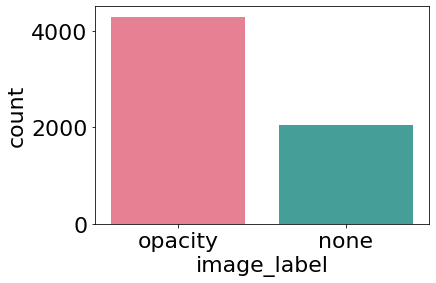

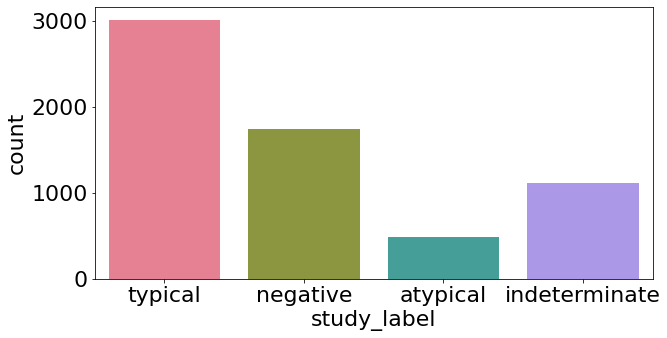

In [12]:
import seaborn as sns

plt.figure()
sns.countplot(df_train['image_label'], palette='husl')
plt.axis='tight'

plt.figure(figsize=(10, 5))
sns.countplot(df_train['study_label'], palette='husl')
plt.axis='tight'
plt.show()

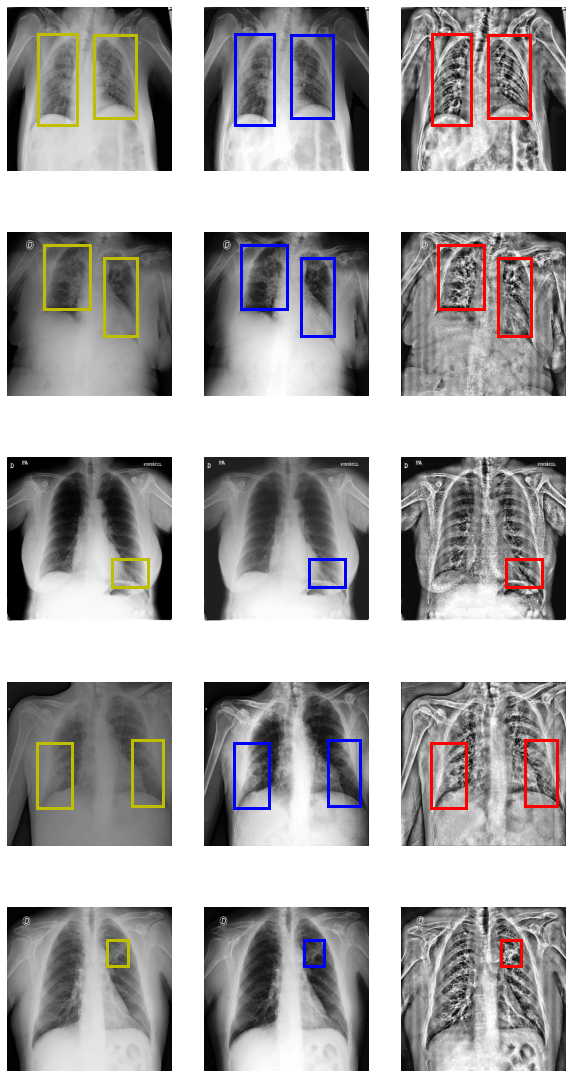

In [13]:
def preprocess_image(img):
    equ_img = exposure.equalize_adapthist(img/255, clip_limit=0.05, kernel_size=24)
    return equ_img

train_dir ='../input/covid-jpg-512/train'
df_opa = df_train[df_train['image_label']=='opacity'].reset_index()
fig, axs = plt.subplots(5, 3, figsize=(10,20))
fig.subplots_adjust(hspace=.2, wspace=.2)
n=5
for i in range(n):
    img = cv2.imread(os.path.join(train_dir, df_opa['id'][i]))
    img_histeq = (exposure.equalize_hist(img/255))
    img_proc = preprocess_image(img)
    axs[i, 0].imshow(img)
    axs[i, 1].imshow(img_histeq)
    axs[i, 2].imshow(img_proc)
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')
    boxes = literal_eval(df_opa['boxes'][i])
    for box in boxes:
        axs[i, 0].add_patch(Rectangle((box['x']*(512/df_opa['dim1'][i]), box['y']*(512/df_opa['dim0'][i])), box['width']*(512/df_opa['dim1'][i]), box['height']*(512/df_opa['dim0'][i]), fill=0, color='y', linewidth=3))
        axs[i, 1].add_patch(Rectangle((box['x']*(512/df_opa['dim1'][i]), box['y']*(512/df_opa['dim0'][i])), box['width']*(512/df_opa['dim1'][i]), box['height']*(512/df_opa['dim0'][i]), fill=0, color='b', linewidth=3))
        axs[i, 2].add_patch(Rectangle((box['x']*(512/df_opa['dim1'][i]), box['y']*(512/df_opa['dim0'][i])), box['width']*(512/df_opa['dim1'][i]), box['height']*(512/df_opa['dim0'][i]), fill=0, color='r', linewidth=3))
    
plt.show()

# Visualization

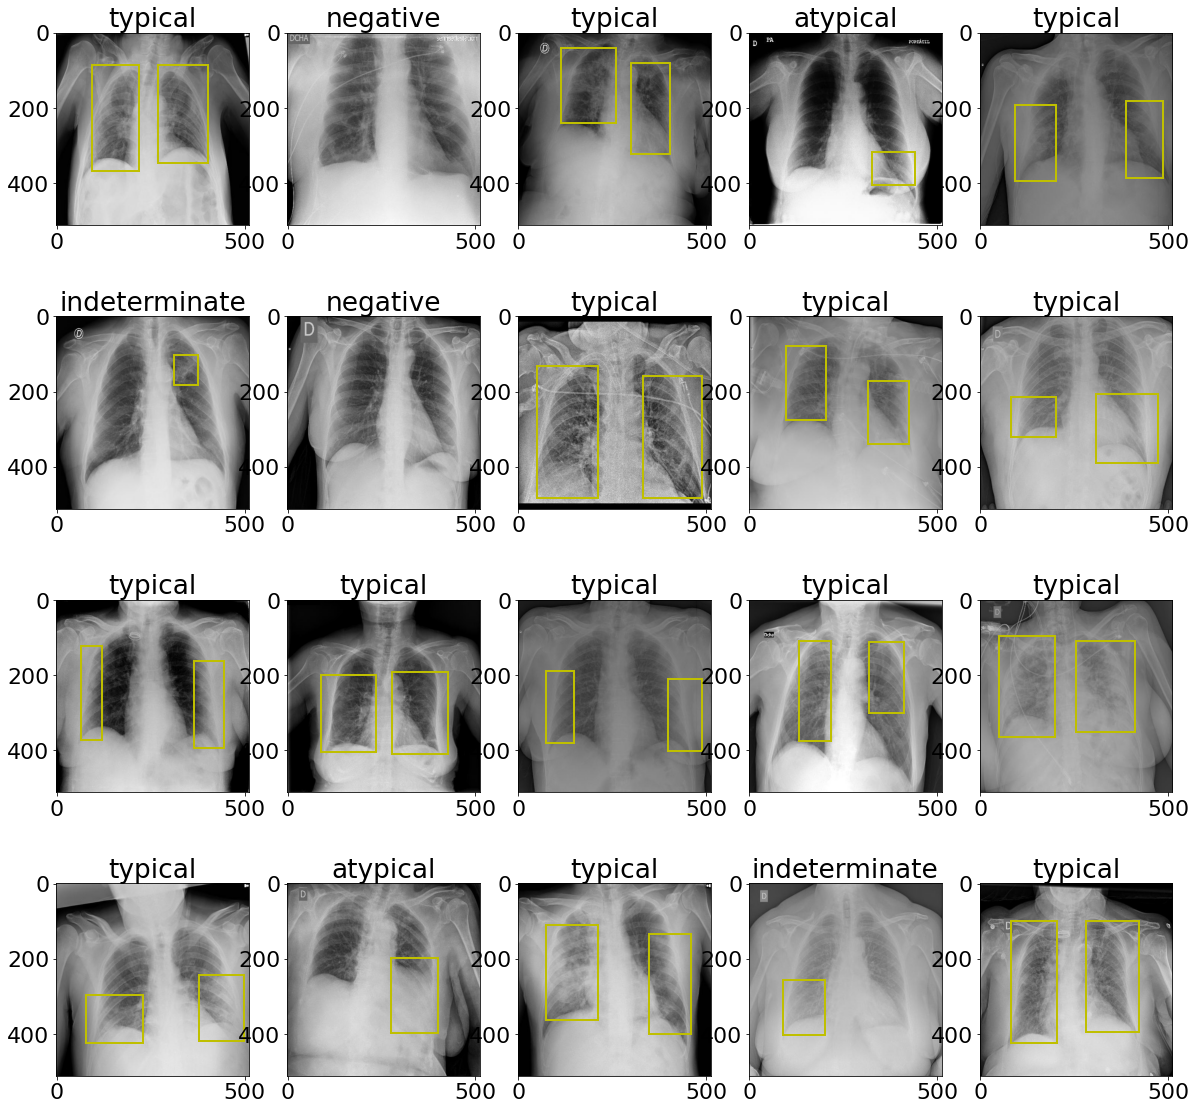

In [14]:
n = 20
train_dir = '../input/covid-jpg-512/train'
fig, axs = plt.subplots(4, 5, figsize=(20,20))
fig.subplots_adjust(hspace=.2, wspace=.2)
axs = axs.ravel()
for i in range(n):
    img = cv2.imread(os.path.join(train_dir, df_train['id'][i]))
    axs[i].imshow(img)
    if type(df_train['boxes'][i])==str:
        boxes = literal_eval(df_train['boxes'][i])
        for box in boxes:
            axs[i].add_patch(Rectangle((box['x']*(512/df_train['dim1'][i]), box['y']*(512/df_train['dim0'][i])), box['width']*(512/df_train['dim1'][i]), box['height']*(512/df_train['dim0'][i]), fill=0, color='y', linewidth=2))
            axs[i].set_title(df_train['study_label'][i])
    else:
        axs[i].set_title(df_train['study_label'][i])

# PreProcessing

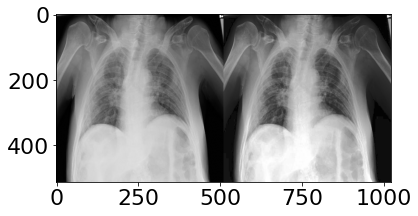

In [15]:
def preprocess_image(img):
    equ_img = (exposure.equalize_hist(img/255))
    return equ_img

im= cv2.imread(train_dir+'/'+df_train['id'][0])
im2 = preprocess_image(im)
res = np.concatenate((im/255, im2), axis=1)
plt.imshow(res)
plt.show()

# ImageGenerators and Augmentations

In [16]:
img_size = 299
batch_size = 16

image_generator = ImageDataGenerator(
        validation_split=0.2,
        #rotation_range=20,
        horizontal_flip = True,
        zoom_range = 0.1,
        #shear_range = 0.1,
        brightness_range = [0.8, 1.1],
        fill_mode='nearest',
        preprocessing_function=preprocess_image
)

image_generator_valid = ImageDataGenerator(validation_split=0.2,preprocessing_function=preprocess_image)

train_generator = image_generator.flow_from_dataframe(
        dataframe = df_train,
        directory='../input/covid-jpg-512/train',
        x_col = 'id',
        y_col =  'image_label',  
        target_size=(img_size, img_size),
        batch_size=batch_size,
        subset='training', seed = 23) 

valid_generator=image_generator_valid.flow_from_dataframe(
    dataframe = df_train,
    directory='../input/covid-jpg-512/train',
    x_col = 'id',
    y_col = 'image_label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation', shuffle=False, seed=23) 

Found 5068 validated image filenames belonging to 2 classes.
Found 1266 validated image filenames belonging to 2 classes.


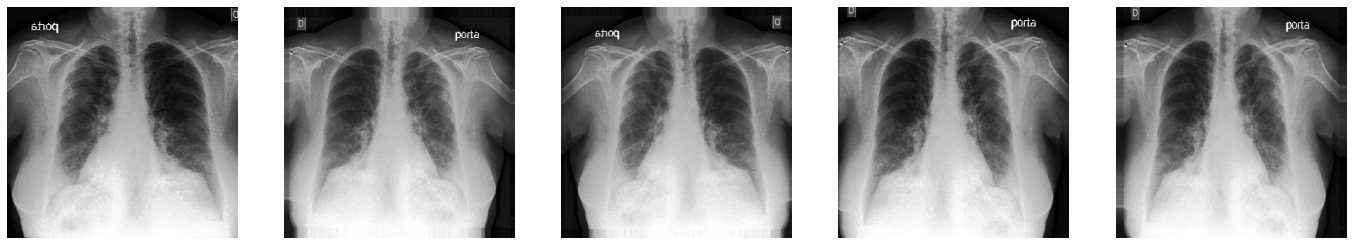

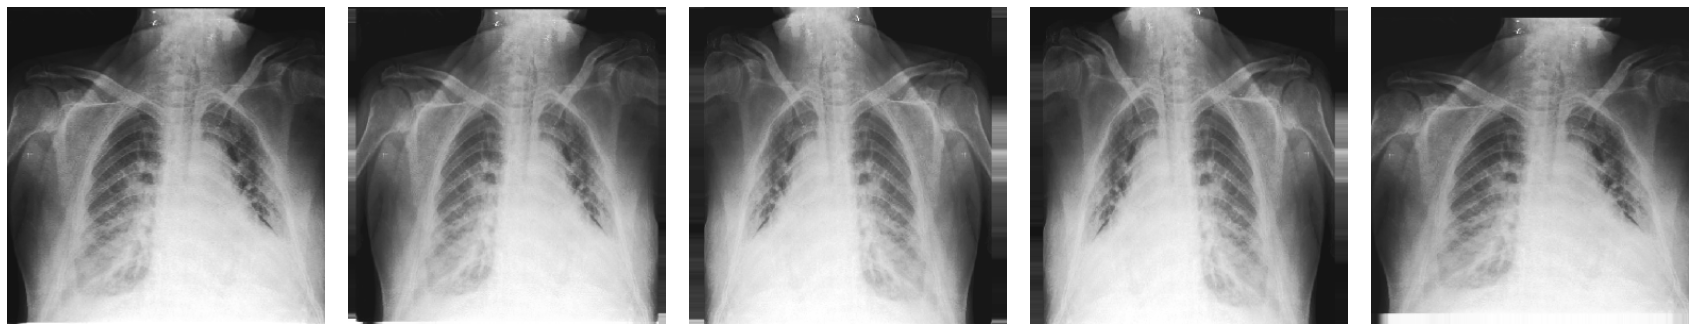

In [17]:
for j in range(2):
    aug_images = [train_generator[0][0][j] for i in range(5)]
    fig, axes = plt.subplots(1, 5, figsize=(24,24))
    axes = axes.flatten()
    for img, ax in zip(aug_images, axes):
        ax.imshow(img)
        ax.axis('off')
plt.tight_layout()
plt.show()

# Architecture

In [18]:
pre_model = Xception(weights='imagenet', 
                  include_top = False, 
                  input_shape=(img_size, img_size, 3))
pre_model.trainable=True

83689472/83683744 [==============================] - 1s 0us/step


In [19]:
x = pre_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x)
model = Model(pre_model.input, output)
#model.summary()

In [20]:
#plot_model(model)

In [21]:
model.compile(Adam(lr=1e-3),loss='binary_crossentropy',metrics='accuracy')

In [22]:
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, verbose = 1, 
                                min_delta = 1e-4, min_lr = 1e-6, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 5, mode = 'min', 
                    restore_best_weights = True, verbose = 1)

ckp = ModelCheckpoint('model.h5',monitor = 'val_loss',
                      verbose = 0, save_best_only = True, mode = 'min')

history = model.fit(
      train_generator,
      epochs=25,
      validation_data=valid_generator,
      callbacks=[es,rlr, ckp],
      verbose=1)

K.clear_session()

Epoch 1/25
317/317 [==============================] - 263s 799ms/step - loss: 0.5478 - accuracy: 0.7390 - val_loss: 1.6010 - val_accuracy: 0.5490
Epoch 2/25
317/317 [==============================] - 227s 714ms/step - loss: 0.4887 - accuracy: 0.7663 - val_loss: 0.5579 - val_accuracy: 0.7243
Epoch 3/25
317/317 [==============================] - 226s 713ms/step - loss: 0.4699 - accuracy: 0.7798 - val_loss: 3.3384 - val_accuracy: 0.3626
Epoch 4/25
317/317 [==============================] - 227s 714ms/step - loss: 0.4541 - accuracy: 0.7929 - val_loss: 0.6021 - val_accuracy: 0.7520

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/25
317/317 [==============================] - 227s 716ms/step - loss: 0.4197 - accuracy: 0.7994 - val_loss: 0.5053 - val_accuracy: 0.7709
Epoch 6/25
317/317 [==============================] - 226s 714ms/step - loss: 0.3910 - accuracy: 0.8269 - val_loss: 0.4788 - val_accuracy: 0.7780
Epoch 7/25
317/317 [======================

In [23]:
actual =  valid_generator.labels
preds = np.argmax(model.predict(valid_generator), axis=1)
cfmx = confusion_matrix(actual, preds)
acc = accuracy_score(actual, preds)
print ('Test Accuracy:', acc )
print('Confusion matrix:', cfmx)

Test Accuracy: 0.7796208530805687
Confusion matrix: tf.Tensor(
[[292 164]
 [115 695]], shape=(2, 2), dtype=int32)


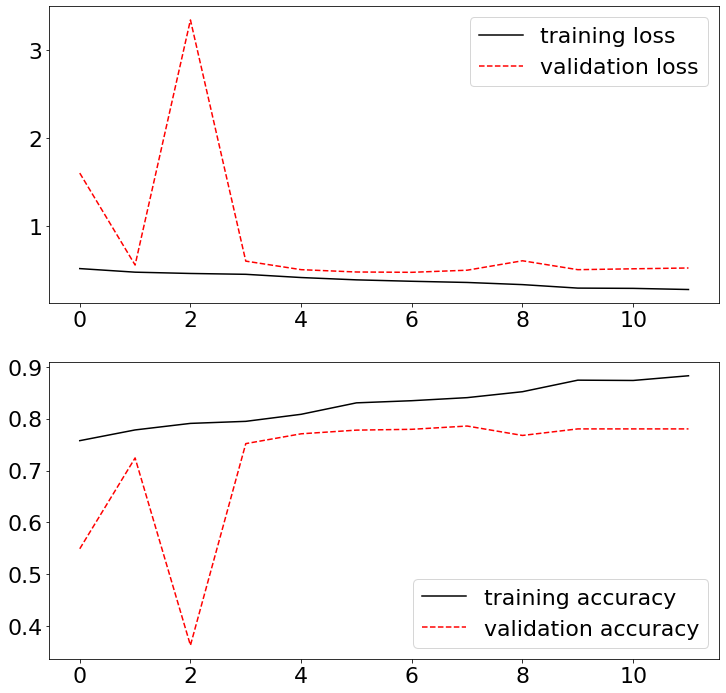

In [24]:
hist = pd.DataFrame(history.history)
fig, (ax1, ax2) = plt.subplots(figsize=(12,12),nrows=2, ncols=1)
hist['loss'].plot(ax=ax1,c='k',label='training loss')
hist['val_loss'].plot(ax=ax1,c='r',linestyle='--', label='validation loss')
ax1.legend()
hist['accuracy'].plot(ax=ax2,c='k',label='training accuracy')
hist['val_accuracy'].plot(ax=ax2,c='r',linestyle='--',label='validation accuracy')
ax2.legend()
plt.show()